# Image Editing with InstructPix2Pix and OpenVINO

The InstructPix2Pix is a conditional diffusion model that edits images based on written instructions provided by the user.
Generative image editing models traditionally target a single editing task like style transfer or translation between image domains. Text guidance gives us an opportunity to solve multiple tasks with a single model.
The InstructPix2Pix method works different than existing text-based image editing in that it enables editing from instructions that tell the model what action to perform instead of using text labels, captions or descriptions of input/output images. A key benefit of following editing instructions is that the user can just tell the model exactly what to do in natural written text. There is no need for the user to provide extra information, such as example images or descriptions of visual content that remain constant between the input and output images. More details about this approach can be found in this [paper](https://arxiv.org/pdf/2211.09800.pdf) and [repository](https://github.com/timothybrooks/instruct-pix2pix).

This notebook demonstrates how to convert and run the InstructPix2Pix model using OpenVINO.

Notebook contains the following steps:
1. Convert PyTorch models to ONNX format.
2. Convert ONNX models to OpenVINO IR format using Model Optimizer tool.
3. Run InstructPix2Pix pipeline with OpenVINO.

## Prerequisites

Install necessary packages

In [1]:
!pip install "transformers>=4.25.1" accelerate
!pip install "git+https://github.com/huggingface/diffusers.git"

  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-lsaso402
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-lsaso402
  Resolved https://github.com/huggingface/diffusers.git to commit b03b5d2f3908e65e6594271f34422ee9a8686b0b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Create Pytorch Models pipeline

`StableDiffusionInstructPix2PixPipeline` is an end-to-end inference pipeline that you can use to edit images from text instructions with just a few lines of code provided as part 🤗🧨[diffusers](https://huggingface.co/docs/diffusers/index) library.

First, we load the pre-trained weights of all components of the model.

> *Please, note, that the first time model loading can takes some time due to downloading weights, downloading speed depends from your internet connection.*

In [2]:
import torch
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler
model_id = "timbrooks/instruct-pix2pix"
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float32, safety_checker=None)
scheduler_config = pipe.scheduler.config

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

## Convert Models to OpenVINO IR

OpenVINO supports PyTorch\* through export to the ONNX\* format. We will use `torch.onnx.export` function for obtaining ONNX model, 
you can learn more in the [PyTorch documentation](https://pytorch.org/docs/stable/onnx.html). We need to provide a model object, input data for model tracing and a path for saving the model.Optionally, we can provide target onnx opset for conversion and other parameters specified in documentation (e.g. input and output names or dynamic shapes).

While ONNX models are directly supported by OpenVINO™ runtime, it can be useful to convert them to OpenVINO Intermediate Representation (IR) format to take advantage of advanced OpenVINO optimization tools and features. We will use the OpenVINO Model Optimizer tool to convert to IR format and compress weights to FP16 format. 

The InstructPix2Pix model is based on Stable Diffusion, a large-scale text-to-image latent diffusion model. You can find more details about how to run Stable Diffusion for text-to-image generation with OpenVINO in a separate [tutorial](../225-stable-diffusion-text-to-image/225-stable-diffusion-text-to-image.ipynb). 


The model consists of 3 important parts:
* Text Encoder to create conditions from a text prompt
* Unet for step-by-step denoising latent image representation
* Autoencoder (VAE) to encode the initial image to latent space for starting the denoising process and decoding latent space to image when denoising is complete.

Let's convert each part

### Text Encoder

The text-encoder is responsible for transforming the input prompt, e.g. "a photo of an astronaut riding a horse" into an embedding space that can be understood by the UNet. It is usually a simple transformer-based encoder that maps a sequence of input tokens to a sequence of latent text embeddings.

Input of text encoder is tensor `input_ids` which contains indexes of tokens from text processed by tokenizer and padded to maximum length accepted by model. Model outputs are 2 tensors: `last_hidden_state` - hidden state from the last MultiHeadAttention layer in model and `pooler_out` - Pooled output for whole model hidden states. We will use `opset_version=14`, because model contains `triu` operation, supported in ONNX only starting from this opset.

In [3]:
from pathlib import Path
from openvino.tools import mo
from openvino.runtime import serialize, Core

core = Core()

TEXT_ENCODER_ONNX_PATH = Path('text_encoder.onnx')
TEXT_ENCODER_OV_PATH = TEXT_ENCODER_ONNX_PATH.with_suffix('.xml')


def convert_encoder_onnx(pipe: StableDiffusionInstructPix2PixPipeline, onnx_path: Path):
    """
    Convert Text Encoder model to ONNX. 
    Function accepts pipeline, prepares example inputs for ONNX conversion via torch.export, 
    Parameters: 
        pipe (StableDiffusionInstructPix2PixPipeline): InstrcutPix2Pix pipeline
        onnx_path (Path): File for storing onnx model
    Returns:
        None
    """
    if not onnx_path.exists():
        text = 'a photo of an astronaut riding a horse on mars'
        text_encoder = pipe.text_encoder
        input_ids = pipe.tokenizer(
            text,
            padding="max_length",
            max_length=pipe.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        ).input_ids

        # switch model to inference mode
        text_encoder.eval()

        # disable gradients calculation for reducing memory consumption
        with torch.no_grad():
            # infer model, just to make sure that it works
            text_encoder(input_ids)
            # export model to ONNX format
            torch.onnx.export(
                text_encoder,  # model instance
                input_ids,  # inputs for model tracing
                onnx_path,  # output file for saving result
                # model input name for onnx representation
                input_names=['input_ids'],
                # model output names for onnx representation
                output_names=['last_hidden_state', 'pooler_out'],
                opset_version=14  # onnx opset version for export
            )
        print('Text Encoder successfully converted to ONNX')


if not TEXT_ENCODER_OV_PATH.exists():
    convert_encoder_onnx(pipe, TEXT_ENCODER_ONNX_PATH)
    text_encoder = mo.convert_model(
        TEXT_ENCODER_ONNX_PATH, compress_to_fp16=True)
    serialize(text_encoder, str(TEXT_ENCODER_OV_PATH))
    print('Text Encoder successfully converted to IR')
else:
    text_encoder = core.read_model(TEXT_ENCODER_OV_PATH)
    print(f"Text encoder successfully loaded from {TEXT_ENCODER_OV_PATH}")

Text encoder successfully loaded from text_encoder.xml


### VAE

The VAE model consist of two parts: an encoder and a decoder. 
* The encoder is used to convert the image into a low dimensional latent representation, which will serve as the input to the UNet model. 
* The decoder, conversely, transforms the latent representation back into an image.

In comparison with a text-to-image inference pipeline, where VAE is used only for decoding, our pipeline also involves the original image encoding. As the two parts are used separately in the pipeline on different steps and do not depend on each other, we should convert them into 2 independent models. 

In [4]:
VAE_ENCODER_ONNX_PATH = Path('vae_encoder.onnx')
VAE_ENCODER_OV_PATH = VAE_ENCODER_ONNX_PATH.with_suffix('.xml')


def convert_vae_encoder_onnx(pipe: StableDiffusionInstructPix2PixPipeline, onnx_path: Path):
    """
    Convert VAE model to ONNX, then IR format. 
    Function accepts pipeline, creates wrapper class for export only necessary for inference part, 
    prepares example inputs for ONNX conversion via torch.export, 
    Parameters: 
        pipe (StableDiffusionInstructPix2PixPipeline): InstrcutPix2Pix pipeline
        onnx_path (Path): File for storing onnx model
    Returns:
        None
    """
    class VAEEncoderWrapper(torch.nn.Module):
        def __init__(self, vae):
            super().__init__()
            self.vae = vae

        def forward(self, image):
            return self.vae.encode(image).latent_dist.mode()

    if not onnx_path.exists():
        vae_encoder = VAEEncoderWrapper(pipe.vae)
        vae_encoder.eval()
        image = torch.zeros((1, 3, 512, 512))
        with torch.no_grad():
            torch.onnx.export(vae_encoder, image, onnx_path, input_names=[
                              'image'], output_names=['image_latent'])
        print('VAE encoder successfully converted to ONNX')


if not VAE_ENCODER_OV_PATH.exists():
    convert_vae_encoder_onnx(pipe, VAE_ENCODER_ONNX_PATH)
    vae_encoder = mo.convert_model(VAE_ENCODER_ONNX_PATH, compress_to_fp16=True)
    serialize(vae_encoder, str(VAE_ENCODER_OV_PATH))
    print('VAE encoder successfully converted to IR')
else:
    vae_encoder = core.read_model(VAE_ENCODER_OV_PATH)
    print(f"VAE encoder successfully loaded from {VAE_ENCODER_OV_PATH}")

VAE encoder successfully loaded from vae_encoder.xml


In [5]:
VAE_DECODER_ONNX_PATH = Path('vae_decoder.onnx')
VAE_DECODER_OV_PATH = VAE_DECODER_ONNX_PATH.with_suffix('.xml')


def convert_vae_decoder_onnx(pipe: StableDiffusionInstructPix2PixPipeline, onnx_path: Path):
    """
    Convert VAE model to ONNX, then IR format. 
    Function accepts pipeline, creates wrapper class for export only necessary for inference part, 
    prepares example inputs for ONNX conversion via torch.export, 
    Parameters: 
        pipe (StableDiffusionInstructPix2PixPipeline): InstrcutPix2Pix pipeline
        onnx_path (Path): File for storing onnx model
    Returns:
        None
    """
    class VAEDecoderWrapper(torch.nn.Module):
        def __init__(self, vae):
            super().__init__()
            self.vae = vae

        def forward(self, latents):
            return self.vae.decode(latents)

    if not onnx_path.exists():
        vae_decoder = VAEDecoderWrapper(pipe.vae)
        latents = torch.zeros((1, 4, 64, 64))

        vae_decoder.eval()
        with torch.no_grad():
            torch.onnx.export(vae_decoder, latents, onnx_path, input_names=[
                              'latents'], output_names=['sample'])
        print('VAE decoder successfully converted to ONNX')


if not VAE_DECODER_OV_PATH.exists():
    convert_vae_decoder_onnx(pipe, VAE_DECODER_ONNX_PATH)
    vae_decoder = mo.convert_model(VAE_DECODER_ONNX_PATH, compress_to_fp16=True)
    print('VAE decoder successfully converted to IR')
else:
    vae_decoder = core.read_model(VAE_DECODER_OV_PATH)
    print(f"VAE decoder successfully loaded from {VAE_DECODER_OV_PATH}")

VAE decoder successfully loaded from vae_decoder.xml


### Unet

Unet model has 3 inputs:
* `scaled_latent_model_input` - latent image sample from previous step, generation process has not been started yet, so we will use random noise
* `timestep` - current scheduler step
* `text_embeddings` - hidden state of text encoder.

Model predicts the `sample` state for the next step.

In [6]:
import numpy as np

UNET_ONNX_PATH = Path('unet/unet.onnx')
UNET_OV_PATH = UNET_ONNX_PATH.parents[1] / 'unet.xml'


def convert_unet_onnx(pipe: StableDiffusionInstructPix2PixPipeline, onnx_path: Path):
    """
    Convert Unet model to ONNX, then IR format. 
    Function accepts pipeline, prepares example inputs for ONNX conversion via torch.export, 
    Parameters: 
        pipe (StableDiffusionInstructPix2PixPipeline): InstrcutPix2Pix pipeline
        onnx_path (Path): File for storing onnx model
    Returns:
        None
    """
    if not onnx_path.exists():
        # prepare inputs
        text = 'a photo of an astronaut riding a horse on mars'
        text_encoder = pipe.text_encoder
        input_ids = pipe.tokenizer(
            text,
            padding="max_length",
            max_length=pipe.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        ).input_ids
        with torch.no_grad():
            text_encoder_output = text_encoder(input_ids)
        latents_shape = (3, 8, 512 // 8, 512 // 8)
        latents = torch.randn(latents_shape)
        t = torch.from_numpy(np.array(1, dtype=float))

        # if the model size > 2Gb, it will be represented as ONNX with external data files and we will store it in a separate directory to avoid having a lot of files in current directory
        onnx_path.parent.mkdir(exist_ok=True, parents=True)

        max_length = input_ids.shape[-1]

        # we plan to use unet with classifier free guidance, in this case conditionally generated text embeddings should be concatenated with unconditional
        uncond_input = pipe.tokenizer(
            [""], padding="max_length", max_length=max_length, return_tensors="pt")
        uncond_embeddings = pipe.text_encoder(uncond_input.input_ids)[0]
        encoder_hidden_state = torch.cat(
            [text_encoder_output[0], uncond_embeddings, uncond_embeddings])

        # to make sure that model works
        pipe.unet(latents, t, encoder_hidden_state)[0]

        with torch.no_grad():
            torch.onnx.export(
                pipe.unet,
                (latents, t, encoder_hidden_state), str(onnx_path),
                input_names=['scaled_latent_model_input',
                             'timestep', 'text_embeddings'],
                output_names=['sample']
            )
        print('Unet successfully converted to ONNX')


if not UNET_OV_PATH.exists():
    convert_unet_onnx(pipe, UNET_ONNX_PATH)
    unet = mo.convert_model(UNET_ONNX_PATH, compress_to_fp16=True)
    print('Unet successfully converted to IR')
else:
    unet = core.read_model(UNET_OV_PATH)
    print(f"Unet successfully loaded from {UNET_OV_PATH}")

Unet successfully loaded from unet.xml


## Prepare Inference Pipeline

Putting it all together, let's now take a closer look at how the model inference works by illustrating the logical flow.

![diagram](https://user-images.githubusercontent.com/29454499/214895365-3063ac11-0486-4d9b-9e25-8f469aba5e5d.png)

The InstructPix2Pix model takes both an image and a text prompt as an input. The image is transformed to latent image representations of size $64 \times 64$ using the encoder part of variational autoencoder whereas the text prompt is transformed to text embeddings of size $77 \times 768$ via CLIP's text encoder.

Next the UNet model iteratively *denoises* the random latent image representations while being conditioned on the text embeddings. The output of the UNet, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm. 

The *denoising* process is repeated a given number of times (by default 100) to retrieve step-by-step better latent image representations.
Once complete, the latent image representation is decoded by the decoder part of the variational auto encoder.


In [7]:
from diffusers.pipeline_utils import DiffusionPipeline
from openvino.runtime import Model, Core
from transformers import CLIPTokenizer
from typing import Union, List, Optional, Tuple
import PIL
import cv2


def scale_fit_to_window(dst_width:int, dst_height:int, image_width:int, image_height:int):
    """
    Preprocessing helper function for calculating image size for resize with peserving original aspect ratio 
    and fitting image to specific window size
    
    Parameters:
      dst_width (int): destination window width
      dst_height (int): destination window height
      image_width (int): source image width
      image_height (int): source image height
    Returns:
      result_width (int): calculated width for resize
      result_height (int): calculated height for resize
    """
    im_scale = min(dst_height / image_height, dst_width / image_width)
    return int(im_scale * image_width), int(im_scale * image_height)


def preprocess(image: PIL.Image.Image):
    """
    Image preprocessing function. Takes image in PIL.Image format, resizes it to keep aspect ration and fits to model input window 512x512,
    then converts it to np.ndarray and adds padding with zeros on right or bottom side of image (depends from aspect ratio), after that
    converts data to float32 data type and change range of values from [0, 255] to [-1, 1], finally, converts data layout from planar NHWC to NCHW.
    The function returns preprocessed input tensor and padding size, which can be used in postprocessing.
    
    Parameters:
      image (PIL.Image.Image): input image
    Returns:
       image (np.ndarray): preprocessed image tensor
       pad (Tuple[int]): pading size for each dimension for restoring image size in postprocessing
    """
    src_width, src_height = image.size
    dst_width, dst_height = scale_fit_to_window(
        512, 512, src_width, src_height)
    image = np.array(image.resize((dst_width, dst_height),
                     resample=PIL.Image.Resampling.LANCZOS))[None, :]
    pad_width = 512 - dst_width
    pad_height = 512 - dst_height
    pad = ((0, 0), (0, pad_height), (0, pad_width), (0, 0))
    image = np.pad(image, pad, mode="constant")
    image = image.astype(np.float32) / 255.0
    image = 2.0 * image - 1.0
    image = image.transpose(0, 3, 1, 2)
    return image, pad


def randn_tensor(
    shape: Union[Tuple, List],
    dtype: Optional[np.dtype] = np.float32,
):
    """
    Helper function for generation random values tensor with given shape and data type
    
    Parameters:
      shape (Union[Tuple, List]): shape for filling random values
      dtype (np.dtype, *optiona*, np.float32): data type for result
    Returns:
      latents (np.ndarray): tensor with random values with given data type and shape (usually represents noise in latent space)
    """
    latents = np.random.randn(*shape).astype(dtype)

    return latents


class OVInstructPix2PixPipeline(DiffusionPipeline):
    """
    OpenVINO inference pipeline for InstructPix2Pix
    """
    def __init__(
        self,
        tokenizer: CLIPTokenizer,
        scheduler: EulerAncestralDiscreteScheduler,
        core: Core,
        text_encoder: Model,
        vae_encoder: Model,
        unet: Model,
        vae_decoder: Model,
        device:str = "AUTO"
    ):
        super().__init__()
        self.tokenizer = tokenizer
        self.vae_scale_factor = 8
        self.scheduler = scheduler
        self.load_models(core, device, text_encoder,
                         vae_encoder, unet, vae_decoder)

    def load_models(self, core: Core, device: str, text_encoder: Model, vae_encoder: Model, unet: Model, vae_decoder: Model):
        """
        Function for loading models on device using OpenVINO
        
        Parameters:
          core (Core): OpenVINO runtime Core class instance
          device (str): inference device
          text_encoder (Model): OpenVINO Model object represents text encoder
          vae_encoder (Model): OpenVINO Model object represents vae encoder
          unet (Model): OpenVINO Model object represents unet
          vae_decoder (Model): OpenVINO Model object represents vae decoder
        Returns
          None
        """
        self.text_encoder = core.compile_model(text_encoder, device)
        self.text_encoder_out = self.text_encoder.output(0)
        self.vae_encoder = core.compile_model(vae_encoder, device)
        self.vae_encoder_out = self.vae_encoder.output(0)
        self.unet = core.compile_model(unet, device)
        self.unet_out = self.unet.output(0)
        self.vae_decoder = core.compile_model(vae_decoder)
        self.vae_decoder_out = self.vae_decoder.output(0)

    def __call__(
        self,
        prompt: Union[str, List[str]],
        image: PIL.Image.Image,
        num_inference_steps: int = 10,
        guidance_scale: float = 7.5,
        image_guidance_scale: float = 1.5,
        eta: float = 0.0,
        latents: Optional[np.array] = None,
        output_type: Optional[str] = "pil",
    ):
        """
        Function invoked when calling the pipeline for generation.

        Parameters:
            prompt (`str` or `List[str]`):
                The prompt or prompts to guide the image generation.
            image (`PIL.Image.Image`):
                `Image`, or tensor representing an image batch which will be repainted according to `prompt`.
            num_inference_steps (`int`, *optional*, defaults to 100):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            guidance_scale (`float`, *optional*, defaults to 7.5):
                Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
                `guidance_scale` is defined as `w` of equation 2. of [Imagen
                Paper](https://arxiv.org/pdf/2205.11487.pdf). Guidance scale is enabled by setting `guidance_scale >
                1`. Higher guidance scale encourages to generate images that are closely linked to the text `prompt`,
                usually at the expense of lower image quality. This pipeline requires a value of at least `1`.
            image_guidance_scale (`float`, *optional*, defaults to 1.5):
                Image guidance scale is to push the generated image towards the inital image `image`. Image guidance
                scale is enabled by setting `image_guidance_scale > 1`. Higher image guidance scale encourages to
                generate images that are closely linked to the source image `image`, usually at the expense of lower
                image quality. This pipeline requires a value of at least `1`.
            latents (`torch.FloatTensor`, *optional*):
                Pre-generated noisy latents, sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor will ge generated by sampling using the supplied random `generator`.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): `PIL.Image.Image` or `np.array`.
        Returns:
            image ([List[Union[np.ndarray, PIL.Image.Image]]): generaited images
            
        """

        # 1. Define call parameters
        batch_size = 1 if isinstance(prompt, str) else len(prompt)
        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0 and image_guidance_scale >= 1.0
        # check if scheduler is in sigmas space
        scheduler_is_in_sigma_space = hasattr(self.scheduler, "sigmas")

        # 2. Encode input prompt
        text_embeddings = self._encode_prompt(prompt)

        # 3. Preprocess image
        orig_width, orig_height = image.size
        image, pad = preprocess(image)
        height, width = image.shape[-2:]

        # 4. set timesteps
        self.scheduler.set_timesteps(num_inference_steps)
        timesteps = self.scheduler.timesteps

        # 5. Prepare Image latents
        image_latents = self.prepare_image_latents(
            image,
            do_classifier_free_guidance=do_classifier_free_guidance,
        )

        # 6. Prepare latent variables
        num_channels_latents = 4
        latents = self.prepare_latents(
            batch_size,
            num_channels_latents,
            height,
            width,
            text_embeddings.dtype,
            latents,
        )

        # 7. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # Expand the latents if we are doing classifier free guidance.
                # The latents are expanded 3 times because for pix2pix the guidance\
                # is applied for both the text and the input image.
                latent_model_input = np.concatenate(
                    [latents] * 3) if do_classifier_free_guidance else latents

                # concat latents, image_latents in the channel dimension
                scaled_latent_model_input = self.scheduler.scale_model_input(
                    latent_model_input, t)
                scaled_latent_model_input = np.concatenate(
                    [scaled_latent_model_input, image_latents], axis=1)

                # predict the noise residual
                noise_pred = self.unet([scaled_latent_model_input, t, text_embeddings])[
                    self.unet_out]

                # Hack:
                # For karras style schedulers the model does classifer free guidance using the
                # predicted_original_sample instead of the noise_pred. So we need to compute the
                # predicted_original_sample here if we are using a karras style scheduler.
                if scheduler_is_in_sigma_space:
                    step_index = (self.scheduler.timesteps == t).nonzero().item()
                    sigma = self.scheduler.sigmas[step_index].numpy()
                    noise_pred = latent_model_input - sigma * noise_pred

                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_text, noise_pred_image, noise_pred_uncond = noise_pred[
                        0], noise_pred[1], noise_pred[2]
                    noise_pred = (
                        noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_image) + image_guidance_scale * (noise_pred_image - noise_pred_uncond)
                    )

                # For karras style schedulers the model does classifer free guidance using the
                # predicted_original_sample instead of the noise_pred. But the scheduler.step function
                # expects the noise_pred and computes the predicted_original_sample internally. So we
                # need to overwrite the noise_pred here such that the value of the computed
                # predicted_original_sample is correct.
                if scheduler_is_in_sigma_space:
                    noise_pred = (noise_pred - latents) / (-sigma)

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(torch.from_numpy(noise_pred), t, torch.from_numpy(latents)).prev_sample.numpy()

                # call the callback, if provided
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()

        # 8. Post-processing
        image = self.decode_latents(latents, pad)

        # 9. Convert to PIL
        if output_type == "pil":
            image = self.numpy_to_pil(image)
            image = [img.resize((orig_width, orig_height),
                                PIL.Image.Resampling.LANCZOS) for img in image]
        else:
            image = [cv2.resize(img, (orig_width, orig_width))
                     for img in image]

        return image

    def _encode_prompt(self, prompt:Union[str, List[str]], num_images_per_prompt:int = 1, do_classifier_free_guidance:bool = True):
        """
        Encodes the prompt into text encoder hidden states.

        Parameters:
            prompt (str or list(str)): prompt to be encoded
            num_images_per_prompt (int): number of images that should be generated per prompt
            do_classifier_free_guidance (bool): whether to use classifier free guidance or not
        Returns:
            text_embeddings (np.ndarray): text encoder hidden states
        """
        batch_size = len(prompt) if isinstance(prompt, list) else 1

        # tokenize input prompts
        text_inputs = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="np",
        )
        text_input_ids = text_inputs.input_ids

        text_embeddings = self.text_encoder(
            text_input_ids)[self.text_encoder_out]

        # duplicate text embeddings for each generation per prompt, using mps friendly method
        if num_images_per_prompt != 1:
            bs_embed, seq_len, _ = text_embeddings.shape
            text_embeddings = np.tile(
                text_embeddings, (1, num_images_per_prompt, 1))
            text_embeddings = np.reshape(
                text_embeddings, (bs_embed * num_images_per_prompt, seq_len, -1))

        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance:
            uncond_tokens: List[str]
            uncond_tokens = [""] * batch_size
            max_length = text_input_ids.shape[-1]
            uncond_input = self.tokenizer(
                uncond_tokens,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                return_tensors="np",
            )

            uncond_embeddings = self.text_encoder(uncond_input.input_ids)[
                self.text_encoder_out]

            # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
            seq_len = uncond_embeddings.shape[1]
            uncond_embeddings = np.tile(
                uncond_embeddings, (1, num_images_per_prompt, 1))
            uncond_embeddings = np.reshape(
                uncond_embeddings, (batch_size * num_images_per_prompt, seq_len, -1))

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            text_embeddings = np.concatenate(
                [text_embeddings, uncond_embeddings, uncond_embeddings])

        return text_embeddings

    def prepare_image_latents(
        self, image, batch_size=1, num_images_per_prompt=1, do_classifier_free_guidance=True
    ):
        """
        Encodes input image to latent space using VAE Encoder
        
        Parameters:
           image (np.ndarray): input image tensor
           num_image_per_prompt (int, *optional*, 1): number of image generated for promt
           do_classifier_free_guidance (bool): whether to use classifier free guidance or not
        Returns:
           image_latents: image encoded to latent space
        """

        image = image.astype(np.float32)

        batch_size = batch_size * num_images_per_prompt
        image_latents = self.vae_encoder(image)[self.vae_encoder_out]

        if batch_size > image_latents.shape[0] and batch_size % image_latents.shape[0] == 0:
            # expand image_latents for batch_size
            additional_image_per_prompt = batch_size // image_latents.shape[0]
            image_latents = np.concatenate(
                [image_latents] * additional_image_per_prompt, axis=0)
        elif batch_size > image_latents.shape[0] and batch_size % image_latents.shape[0] != 0:
            raise ValueError(
                f"Cannot duplicate `image` of batch size {image_latents.shape[0]} to {batch_size} text prompts."
            )
        else:
            image_latents = np.concatenate([image_latents], axis=0)

        if do_classifier_free_guidance:
            uncond_image_latents = np.zeros_like(image_latents)
            image_latents = np.concatenate([image_latents, image_latents, uncond_image_latents], axis=0)

        return image_latents

    def prepare_latents(self, batch_size:int, num_channels_latents:int, height:int, width:int, dtype:np.dtype = np.float32, latents:np.ndarray = None):
        """
        Preparing noise to image generation. If initial latents are not provided, they will be generated randomly, 
        then prepared latents scaled by the standard deviation required by the scheduler
        
        Parameters:
           batch_size (int): input batch size
           num_channels_latents (int): number of channels for noise generation
           height (int): image height
           width (int): image width
           dtype (np.dtype, *optional*, np.float32): dtype for latents generation
           latents (np.ndarray, *optional*, None): initial latent noise tensor, if not provided will be generated
        Returns:
           latents (np.ndarray): scaled initial noise for diffusion
        """
        shape = (batch_size, num_channels_latents, height // self.vae_scale_factor, width // self.vae_scale_factor)
        if latents is None:
            latents = randn_tensor(shape, dtype=dtype)
        else:
            latents = latents

        # scale the initial noise by the standard deviation required by the scheduler
        latents = latents * self.scheduler.init_noise_sigma.numpy()
        return latents

    def decode_latents(self, latents:np.array, pad:Tuple[int]):
        """
        Decode predicted image from latent space using VAE Decoder and unpad image result
        
        Parameters:
           latents (np.ndarray): image encoded in diffusion latent space
           pad (Tuple[int]): each side padding sizes obtained on preprocessing step
        Returns:
           image: decoded by VAE decoder image
        """
        latents = 1 / 0.18215 * latents
        image = self.vae_decoder(latents)[self.vae_decoder_out]
        (_, end_h), (_, end_w) = pad[1:3]
        h, w = image.shape[2:]
        unpad_h = h - end_h
        unpad_w = w - end_w
        image = image[:, :, :unpad_h, :unpad_w]
        image = np.clip(image / 2 + 0.5, 0, 1)
        image = np.transpose(image, (0, 2, 3, 1))
        return image

In [8]:
import matplotlib.pyplot as plt


def visualize_results(orig_img:PIL.Image.Image, processed_img:PIL.Image.Image, prompt:str):
    """
    Helper function for results visualization
    
    Parameters:
       orig_img (PIL.Image.Image): original image
       processed_img (PIL.Image.Image): processed image after editing
       prompt (str): text instruction used for editing
    Returns:
       fig (matplotlib.pyplot.Figure): matplotlib generated figure contains drawing result
    """
    orig_title = "Original image"
    fig, axs = plt.subplots(2, 1, figsize=(25, 10), sharex='all', sharey='all')
    list_axes = list(axs.flat)
    for a in list_axes:
        a.set_xticklabels([])
        a.set_yticklabels([])
        a.get_xaxis().set_visible(False)
        a.get_yaxis().set_visible(False)
        a.grid(False)
        a.grid(False)
    list_axes[0].imshow(np.array(orig_img))
    list_axes[1].imshow(np.array(processed_img))
    list_axes[0].set_title(orig_title, fontsize=20) 
    list_axes[1].set_title(f"Prompt: {prompt}", fontsize=20)
    fig.subplots_adjust(wspace=0, hspace=0.10)
    fig.tight_layout()
    return fig

Model tokenizer and scheduler are also important parts of the pipeline. Let's define them and put all components together.
Additionally, you can provide device, e.g. replace `AUTO` with `GPU` for running model inference on GPU.

In [9]:
from transformers import CLIPTokenizer

tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')
scheduler = EulerAncestralDiscreteScheduler.from_config(scheduler_config)

ov_pipe = OVInstructPix2PixPipeline(tokenizer, scheduler, core, text_encoder, vae_encoder, unet, vae_decoder, device="AUTO")

Now, we are ready to define editing instructions and an image for running the inference pipeline. You can find example results generated by the model on this [page](https://www.timothybrooks.com/instruct-pix2pix/), in case you need inspiration.
Optionally, you can also change the random generator seed for latent state initialization and number of steps.
> **Note**: Consider increasing `steps` to get more precise results. A suggested value is `100`, but it will take more time to process.

In [10]:
import ipywidgets as widgets

style = {'description_width': 'initial'}
text_prompt = widgets.Text(value="Replace dog with cat and add snow", description='your text')
num_steps = widgets.IntSlider(min=1, max=100, value=10, description='steps:')
seed = widgets.IntSlider(min=0, max=1024, description='seed: ', value=42)
image_widget = widgets.FileUpload(
    accept='',
    multiple=False,
    description='Upload image',
    style=style
)
widgets.VBox([text_prompt, seed, num_steps, image_widget])

> **Note**: Diffusion process can take some time depending on what hardware you select

In [11]:
import io

default_image_path = "../data/image/coco.jpg"
# read uploaded image
image = PIL.Image.open(io.BytesIO(image_widget.value[-1]['content']) if image_widget.value else default_image_path)
print('Pipeline settings')
print(f'Input text: {text_prompt.value}')
print(f'Seed: {seed.value}')
print(f'Number of steps: {num_steps.value}')
np.random.seed(seed.value)
processed_image = ov_pipe(text_prompt.value, image, num_steps.value)

Pipeline settings
Input text: Replace dog with cat and add snow
Seed: 42
Number of steps: 10


  0%|          | 0/10 [00:00<?, ?it/s]

Now, let's look at the results. The top image represents the original before editing. The bottom image is the result of the editing process. The title between them contains the text instructions used for generation.

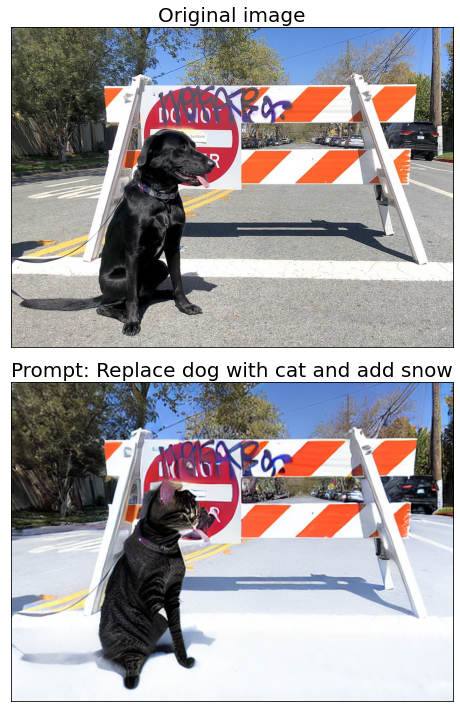

In [12]:
fig = visualize_results(image, processed_image[0], text_prompt.value)

Nice, as we can see the picture has quite a high definition 🔥.